<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC2</p>
<p style="margin: 0; text-align:right;">2023-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 3: Transformers con Keras


<u>Consideraciones generales</u>:

- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

## Instalación de librerias necesarias
Puedes ejecutar las siguientes celdas para instalar las versiones de librerias necesarias

In [ ]:
#!pip3 install tensorflow==2.12.1

## Carga de librerias
A continuación, os dejamos inicializadas la serie de librerías que necesitarás instalar para utilizar en esta PEC3.

In [ ]:
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:

import os
import shutil
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Embedding, Input, Dense, Dropout, Reshape,concatenate
from keras.layers import LSTM, Flatten, Dropout, MultiHeadAttention, Bidirectional, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback

In [ ]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [ ]:
np.random.seed(42)

In [ ]:
%matplotlib inline

# 0. Contexto

En esta PEC vamos a utilizar modelos de transformers, capas de atención, capas bidireccionales y el resto de algoritmos estudiados hasta el momento para construir y entrenar un clasificador gramatical de parafrasia. La parafrasia hace referencia a cuando teniendo una frase, se utilizan expresiones o palabras distintas para expresar lo mismo. Para aclarar este punto veamos un ejemplo de parafrasía:
*  Voy a ir desde Madrid a Barcelona.
*  Me voy a desplazar hasta Barcelona desde Madrid.

Sin embargo, puede ocurrir que utilizando las mismas palabras, el significado sea completamente distinto. A continuación, tenemos un ejemplo de no parafrasia en la que se utilizan las mismas palabras pero cambia radicalmente el significado:
*  Me voy a desplazar desde Vitoria a Madrid.
*  Me voy a desplazar desde Madrid a Vitoria.

La arquitectura neuronal que diseñeñemos, entrenemos y testeemos deberá ser capaz de distinguir si dos frases tienen el mismo significado o no.

Aunque pueda parecer un juego, la complejidad y el reto científico que se plantea es muy elevado y se encontraba totalmente fuera del alcance hasta hace apenas una década. Por un lado, es necesario tener un alto grado de conocimiento del léxico del idioma y por otro lado hay que tener una comprensión profunda de como el contexto, la gramática y las relaciones a larga distancia entre las palabras que generan el significado abstracto de una frase. Las aplicaciones de una arquitectura capaz de hacer esto son muchas, como por ejemplo sistemas de corrección gramatical, de simplificación de textos, de generación de resumenes, etc.   

Para esta PEC se ha elegido la base de datos PAWS(Paraphrase Adversaries from Word Scrambling), en concreto la versión PAW-Wiki. La motivación de esta base de datos es proporcionar un conjuntos de datos de identificación de paráfrasis existentes para entrenar modelos específicos. Esta compuesta por 49401 parafrasis de entrenamiento, 8000 de dev y 8000 de test.


Los objetivos de la práctica son:

* Carga, preprocesado, exploración y visualización de los datos.
* Entrenamiento de un modelo base con los conocimientos adquiridos hasta el momento.
* Comprensión de las capas bidireccionales.
* Comprensión y aplicación de las capas de atención.
* Comprensión y aplicación de bloques transformers básicos.
* Comprensión y aplicación de bloques transformers avanzados.
* Aplicación sobre dominio (downstream models) de arquitecturas preentrenadas basados en transformers.
* Adquisición de conocimientos y capacidad crítica que permita continuar mejorando los resultados.

# 1. Carga de Datos / Análisis / Preprocesado / Visualización

## 1.1. Carga y división de datos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0.5 pts.]:</strong> En esta primera parte realiza lo siguiente:
    
*  Descarga la base de datos paws_wiki utilizando tensorflow_datasets. (https://www.tensorflow.org/datasets/catalog/paws_wiki)
*  Divídelo en train, validation y test.
*  Procesa de forma adecuada los objetos obtenidos con tensorflow_datasets y genera: train_sentence1, train_sentence2, train_labels, val_sentence1, val_sentence2, val_labels, test_sentence1, test_sentence2 y val_labels. Estas nuevas variables deben ser listas (list).
* Muestra los 3 primeros elementos de cada lista. Al mostrarlos, hazlo de forma adecuada en una tabla o con otro método pero que sea algo tipo: frase_train_sentence1, frase1_train_sentence 2, train_label
* Muestra una tabla con las dimesiones de cada objeto.
* Muestra un histograma del tamaño de las frases (en numero de palabras) de train_sentence1. Aseguraté de incluir título y el nombre de los ejes.
    
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> </p>
</div>

In [ ]:
# Cargar el conjunto de datos
data, info = tfds.load('paws_wiki', with_info=True)

# Dividirlo en entrenamiento, validación y test
train_data, validation_data, test_data = data['train'], data['validation'], data['test']

# Obtener el nombre de las etiquetas
labels_names = info.features['label'].names
print(labels_names)

['different_meaning', 'paraphrase']


In [ ]:
# Preprocesar los datos para obtenerlos en un formato adecuado. Una lista de labels y otra lista de etiquetas
def preprocess_data(data_object):
    sentence1 = [item['sentence1'].numpy().decode('utf-8')[0:2000] for item in data_object]
    sentence2 = [item['sentence2'].numpy().decode('utf-8') for item in data_object]
    labels = [item['label'].numpy() for item in data_object]
    return sentence1, sentence2, labels

train_sentence1, train_sentence2, train_labels = preprocess_data(train_data)
val_sentence1, val_sentence2, val_labels = preprocess_data(validation_data)
test_sentence1, test_sentence2, test_labels = preprocess_data(test_data)

In [ ]:
# Muestra los 3 primeros elementos de train
for i in range(3):
    print(train_sentence1[i], train_sentence2[i], train_labels[i])

Hugo Käch died on December 31 , 2003 in Schaffhausen near Flurlingen , Germany . Hugo Käch died on 31 December 2003 in Flurlingen near Schaffhausen . 0
In 2013 Peter married Anna Barattin while Julia is married to Nicholas Furiuele , both are members of the band Shantih Shantih . Peter Anna Barattin married in 2013 while Julia was married to Nicholas Furiuele , both of whom are members of the band Shantih Shantih . 1
The recent Sierra Leone Civil War was secular in nature featuring members of Tribal , Muslim , and Christian faiths fighting on both sides of the conflict . The recent civil war in Sierra Leone was secular in nature , with members of Christian , Muslim , and tribal faith fighting on both sides of the conflict . 1


In [ ]:
# Muestra los 3 primeros elementos de val
for i in range(3):
    print(val_sentence1[i], val_sentence2[i], val_labels[i])

The plant may have some medical properties and has been used in traditional medicine in South Asia and in traditional Chinese medicine . The plant can have some medical properties and has been used in traditional Chinese medicine in South Asia and traditional medicine . 0
This was recorded in two separate inscriptions from his corpse hill Medinet Habu , which are physically long and somewhat different from one another . This was recorded in two long inscriptions from his body horde Medinet Habu , which are physically separate and somewhat different from one another . 0
Malcolm Fraser , who had defeated Whitlam in a landslide at the federal election in December 1975 , offered Egerton the knighthood for serving the trade union movement . Whitlam , who had defeated Malcolm Fraser in a landslide at the federal election in December 1975 , offered Egerton the knighthood for serving the trade union movement . 0


In [ ]:
# Muestra los 3 primeros elementos de test
for i in range(3):
    print(test_sentence1[i], test_sentence2[i], test_labels[i])

The NRA has referred to the NAGR leader , Dudley Brown , as '' Al Sharpton of the gun movement `` . The NRA has referred to the NAGR - leader Al Sharpton as '' the Dudley Brown of the gun movement `` . 0
The layout of Belmont is similar to that of Twin Pines park and other parks in Davey Glen Park . The Belmont layout is similar to that of Twin Pines Park and other parks in Davey Glen Park . 1
Road access to Island Harbour is via Mill Lane , which connects to North Fairlee Road ( A3054 ) . The access to North Fairlee Road is via Mill Lane , which connects to the Island Harbour ( A3054 ) . 0


In [ ]:
# Construye una tabla con las dimensiones de los elementos train, val y test
table = [[len(train_sentence1), len(val_sentence1), len(test_sentence1)],
         [len(train_sentence2), len(val_sentence2), len(test_sentence2)],
         [len(train_labels), len(val_labels), len(test_labels)]]
df = pd.DataFrame(table, columns = ['train', 'val', 'test'], index=['sentence1', 'sentence2', 'label'])
print(df)

           train   val  test
sentence1  49401  8000  8000
sentence2  49401  8000  8000
label      49401  8000  8000


Text(0.5, 1.0, 'Sentence length for train_sentence1')

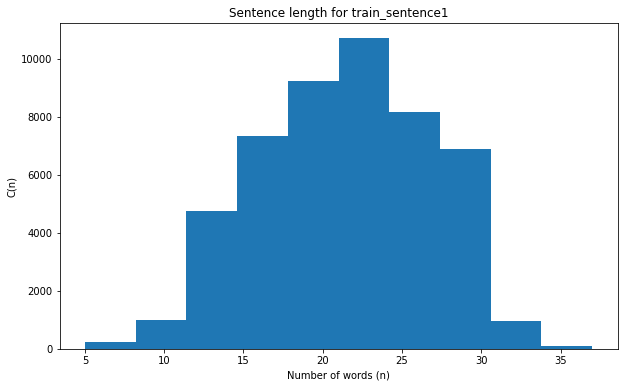

In [ ]:
# Histograma
word_counts = [len(sent.split()) for sent in train_sentence1]
plt.figure(figsize=(10, 6))

plt.hist(word_counts, 10)
plt.xlabel('Number of words (n)')
plt.ylabel('C(n)')
plt.title('Sentence length for train_sentence1')


## 1.2. Procesado de las etiquetas y tokenización

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0.5 pts.]:</strong> Utiliza la clase tf.keras.preprocessing.text.Tokenizer de tensorflow para procesar las frases y convertirlas a números. Límita el número de palabras distintas (vocabulario) a 5000 palabras y utiliza como token para palabras fuera de vocabulario la opción oov_token=-OOV-. Para ello:
    
*  Entrenaló sobre el conjunto train_sentence1 + train_sentence2.
*  Muestra una frase cualquiera. Tokenizalá y muestralá codificada. Decocificalá y vuelve a mostrarla.
*  ¿Como funciona un tokenizador y que funciones tienen sus parámetros?
    

</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> </p>
</div>

In [ ]:
# Número de palabras
num_words=5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words,
                                                  oov_token='-OOV-')
tokenizer.fit_on_texts(train_sentence1 + train_sentence2)
tokenized = tokenizer.texts_to_sequences(train_sentence1)

example_idx = 0  # Index of the sentence to use as an example
input_ids = tokenized[example_idx]
decoded_sentence = tokenizer.sequences_to_texts([input_ids])[0]


print("Original Sentence:", train_sentence1[example_idx])
print("Tokenized Sentence:", input_ids)
print("Detokenized Sentence:", decoded_sentence)


Original Sentence: Hugo Käch died on December 31 , 2003 in Schaffhausen near Flurlingen , Germany .
Tokenized Sentence: [4719, 1, 70, 11, 134, 405, 330, 3, 1, 147, 1, 283]
Detokenized Sentence: hugo -OOV- died on december 31 2003 in -OOV- near -OOV- germany


## 1.3. Preparación de los datos para el entrenamiento

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong> Vamos a combinar lo anterior y vamos a dejar listos nuestros datos para el entrenamiento:
    
*  Calcula cual es el tamaño de la frase más larga en train_sentence1 y train_sentence2.
*  Tokeniza train_sentence1, train_sentence2, val_sentence1, val_sentence2, test_sentence1 y test_sentence2.
*  Utiliza la función preprocessing.sequence.pad_sequences con ceros para que todas las frases tokenizadas tengan la misma longitud igual al tamaño máximo de la frase  más larga.
* Transforma a numpy.arrays las variables Y_train, y_val e y_test.

    
Las dimensiones finales deben ser:
*  X_train: (49401, 2, 40)
*  X_val: (8000, 2, 40)
*  X_test: (8000, 2, 40)
*  y_train: (49401,)
*  y_val: (8000,)
*  y_test: (8000,)
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> </p>
</div>

In [ ]:
# Longitud máxima
max_length = max([len(tokens) for tokens in tokenized[0::]])
print("Longitud máxima:", max_length)

Longitud máxima: 40


In [ ]:
# Tokenización
X_train_tok1 = tokenizer.texts_to_sequences(train_sentence1)
X_train_tok2 = tokenizer.texts_to_sequences(train_sentence2)
X_val_tok1 = tokenizer.texts_to_sequences(val_sentence1)
X_val_tok2 = tokenizer.texts_to_sequences(val_sentence2)
X_test_tok1 = tokenizer.texts_to_sequences(test_sentence1)
X_test_tok2 = tokenizer.texts_to_sequences(test_sentence2)

y_train = np.asarray(train_labels)
y_val = np.asarray(val_labels)
y_test = np.asarray(test_labels)

In [ ]:
# Pad
X_train1 = tf.keras.preprocessing.sequence.pad_sequences(X_train_tok1, maxlen=max_length)
X_train2 = tf.keras.preprocessing.sequence.pad_sequences(X_train_tok2, maxlen=max_length)

X_val1 = tf.keras.preprocessing.sequence.pad_sequences(X_val_tok1, maxlen=max_length)
X_val2 = tf.keras.preprocessing.sequence.pad_sequences(X_val_tok2, maxlen=max_length)

X_test1 = tf.keras.preprocessing.sequence.pad_sequences(X_test_tok1, maxlen=max_length)
X_test2 = tf.keras.preprocessing.sequence.pad_sequences(X_test_tok2, maxlen=max_length)

In [ ]:
# # Dimensiones
print("X_train1:", X_train1.shape)
print("X_train2:", X_train2.shape)
print("X_val1:", X_val1.shape)
print("X_val2:", X_val1.shape)
print("X_test1:", X_test1.shape)
print("X_test2:", X_test2.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)

X_train1: (49401, 40)
X_train2: (49401, 40)
X_val1: (8000, 40)
X_val2: (8000, 40)
X_test1: (8000, 40)
X_test2: (8000, 40)
y_train: (49401,)
y_val: (8000,)
y_test: (8000,)


# 2 Entrenando un clasificador

En este apartado vamos a ir construyendo una arquitectura que contendrá todos los elementos típicos de una arquitectura transformer. La gran ventaja de las arquitecturas con elementos de atención es su capacidad de escalar cuando se entrenan con una gran capacidad de datos. En este caso, dado que la capacidad de computo es limitada, el número de datos con los que trabajaremos será pequeño por lo que es muy probable que la arquitectura presente sobreajuste muy pronto.

## 2.1 Modelo base aleatorio

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong> El primero paso para saber si el modelo clasificador que vamos a entrenar es suficientemente bueno, sería compararlo con un modelo base aleatorio. Para ello:
    
*  Muestra si el conjunto de datos de train, val y test esta balanceado. En caso de que no lo esté, la proporción de desbalanceo se mantiene entren train, val y test?
*  Cual sería la accuracy de un modelo aleatorio condicionado a que conocemos la proporción de datos que hay de cada clase en train.

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> </p>
</div>

In [ ]:
# Balanceo de datos
from collections import Counter

a = Counter(y_train)
b = Counter(y_val)
c = Counter(y_test)

print("Número de clases en train: ", list(a.values()))
print("Número de clases en train: ", list(b.values()))
print("Número de clases en train: ", list(c.values()))
print()

# Se mantiene la proporcion
print("Desbalanceo en train: ", round(list(a.values())[1]/len(y_train), 3))
print("Desbalanceo en val: ", round(list(b.values())[1]/len(y_val), 3))
print("Desbalanceo en test: ", round(list(c.values())[1]/len(y_test), 3))


Número de clases en train:  [27572, 21829]
Número de clases en train:  [4461, 3539]
Número de clases en train:  [4464, 3536]

Desbalanceo en train:  0.442
Desbalanceo en val:  0.442
Desbalanceo en test:  0.442


In [ ]:
print(a)

Counter({0: 27572, 1: 21829})


In [ ]:
# Modelo aleatorio base
import random
from sklearn import metrics

def return_random_sol(size=8000, threshold=0.5):
    list_val = []
    for i in range(8000):
        if random.random() < threshold:
            list_val.append(1)
        else:
            list_val.append(0)
    return(list_val)


In [ ]:
# Como estan igualmente desbalanceados en val y test. Solo necesitamos hacerlo para uno de ellos.
# Modelo random con información sobre el desbalanceo
list_acc_informado = [metrics.accuracy_score(y_test, return_random_sol(threshold=0.442)) for i in range(200)]
print("Accuracy del modelo random con información: ", round(np.mean(list_acc_informado),2))


Accuracy del modelo random con información:  0.51


## 2.2. Modelo base con una capa de atención de varias cabezas

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [2 pts.]:</strong> En este apartado vamos a contruir la base de la arquitectura. Para ello:
    
*  El modelo tendrá dos inputs. Estos inputs son las frases que queremos comparar y decidir si son parafrases.
*  Cada una de ellas será la entrada de una Embedding layer con un output_dim de 20 y resto de dimensiones adecuadas.
*  A continuación se alimentarán a una capa MultiHeadAttention de 2 cabezas y cuya key_dim es la output_dim de la capa anterior
*  Después se pasa por una capa Flatten.
*  A continuación se concatenan ambos vectores.
*  Finalmente añade una última capa classificadora de una neurona y activación sigmoide
*  Muestra el resumen del modelo y el diagrama de bloques.
*  Entrena el modelo y obten los resultados sobre test. Muestra las curvas de entrenamiento
*  Comenta y discute lo que has realizado



<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> </p>
</div>

In [ ]:
embedding_dim = 20
trainable_embeddings = True
input_length = max_length

X1_input = Input(shape=(input_length,), name="input_X1")
X2_input = Input(shape=(input_length,), name="input_X2")

embeddor = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=input_length, trainable=trainable_embeddings)
multihead = MultiHeadAttention(num_heads=2, key_dim=embedding_dim, dropout=0)
flatten = Flatten()

x1 = embeddor(X1_input)
x1 = multihead(x1, x1)

x2 = embeddor(X2_input)
x2 = multihead(x2, x2)

x1 = flatten(x1)
x2 = flatten(x2)

x = concatenate([x1, x2])

output = Dense(1, activation="sigmoid", name="output")(x)

model = Model(inputs=[X1_input, X2_input], outputs=output, name="Base")

In [ ]:
model.compile(optimizer="Adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])

model.summary()

Model: "Base"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_X1 (InputLayer)          [(None, 40)]         0           []                               
                                                                                                  
 input_X2 (InputLayer)          [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 20)       100000      ['input_X1[0][0]',               
                                                                  'input_X2[0][0]']               
                                                                                                  
 multi_head_attention (MultiHea  (None, 40, 20)      3340        ['embedding[0][0]',           

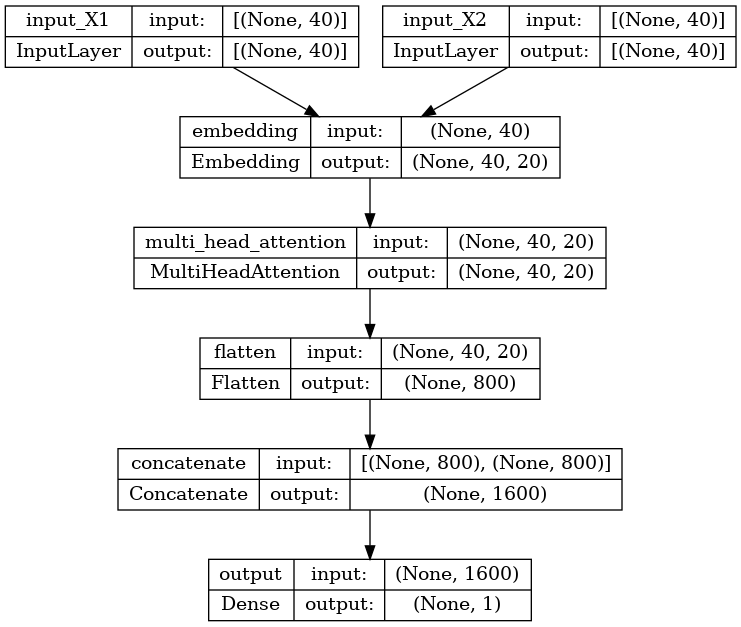

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)
callbacks = [es]

epochs = 20
train_history = model.fit([X_train1, X_train2],
                          y_train,
                          validation_data=([X_val1, X_val2], y_val),
                          batch_size=64, epochs=epochs, callbacks=callbacks)

Epoch 1/20
772/772 [==============================] - 4s 5ms/step - loss: 0.6855 - accuracy: 0.5644 - val_loss: 0.6825 - val_accuracy: 0.5602
Epoch 2/20
772/772 [==============================] - 4s 5ms/step - loss: 0.6718 - accuracy: 0.5936 - val_loss: 0.6863 - val_accuracy: 0.5556
Epoch 3/20
772/772 [==============================] - 4s 5ms/step - loss: 0.6606 - accuracy: 0.6017 - val_loss: 0.6941 - val_accuracy: 0.5537
Epoch 3: early stopping


In [ ]:
def plot_training(n_epochs, mfit):
    N = n_epochs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    fig.suptitle('Training Loss and Accuracy')

    ax1.plot(np.arange(0, N), mfit.history["accuracy"], label="train")
    ax1.plot(np.arange(0, N), mfit.history["val_accuracy"], label="val")
    ax1.set_title("Accuracy")
    ax1.set_xlabel("Epoch #")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")

    ax2.plot(np.arange(0, N), mfit.history["loss"], label="train")
    ax2.plot(np.arange(0, N), mfit.history["val_loss"], label="val")
    ax2.set_title("Loss")
    ax2.set_xlabel("Epoch #")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")

    plt.show()

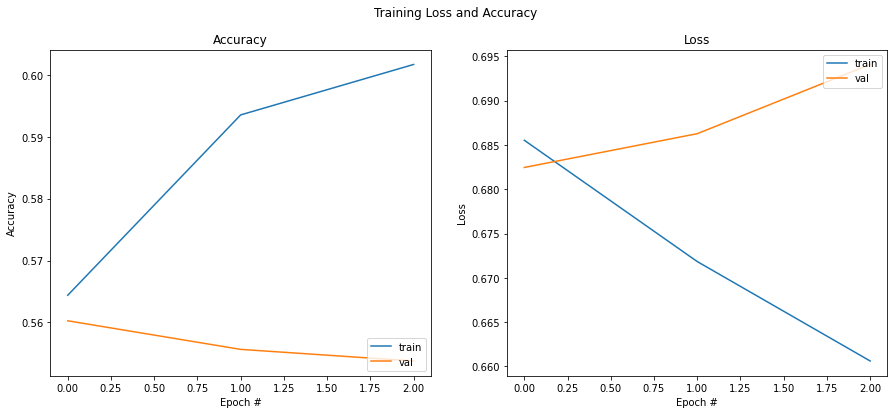

----------
Loss: 0.68
Accuracy: 56.52 %


In [ ]:
n_epochs = len(train_history.history["loss"])
plot_training(n_epochs, train_history)

score = model.evaluate([X_test1, X_test2], y_test, verbose=0)
print ("-"*10)
print ("Loss: {:.2f}".format((score[0])))
print ("Accuracy: {:.2f} %".format(score[1]*100))

## Modifica la capa de atención

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [2 pts.]:</strong> Normalmente las capas de embedding que alimentan posteriormente a capas de atención es interesante que conserven información no solo sobre los vectores sino sobre las posiciones de los textos. Para ello construye una clase:
    
*  Esta clase calcula con una capa embedding como en el caso anterior los embeddings de los tokens.
*  Adicionalmente calcula los embeddings correspondientes a las posiciones del las palabras. Para ello el input_dim será el tamaño máximo de las frases calculado anteriormente.
*  Finalmente concatena ambos embeddings.
*  Sustituye la capa de Embeddings del ejercicio anterior por esta nueva que has creado y al igual que antes muestra el resumen del modelo, los diagramas, el entrenamiento y el resultado.
*  Comenta y discute lo que has realizado


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> </p>
</div>

In [ ]:
# Classe de Embedding nueva
class TokenAndPositionEmbedding(Layer):
    def __init__(self, max_length, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=max_length, output_dim=embed_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=tf.shape(x)[-1], delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
embedding_dim = 20
input_length = max_length

X1_input = Input(shape=(input_length,), name="input_X1")
X2_input = Input(shape=(input_length,), name="input_X2")

embeddor = TokenAndPositionEmbedding(max_length, num_words, embedding_dim)
multihead = MultiHeadAttention(num_heads=2, key_dim=embedding_dim, dropout=0)
flatten = Flatten()

x1 = embeddor(X1_input)
x1 = multihead(x1, x1)

x2 = embeddor(X2_input)
x2 = multihead(x2, x2)

x1 = flatten(x1)
x2 = flatten(x2)

x = concatenate([x1, x2])
output = Dense(1, activation="sigmoid", name="output")(x)

model = Model(inputs=[X1_input, X2_input], outputs=output, name="Attention")

In [ ]:
model.compile(optimizer="Adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])

model.summary()

Model: "Attention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_X1 (InputLayer)          [(None, 40)]         0           []                               
                                                                                                  
 input_X2 (InputLayer)          [(None, 40)]         0           []                               
                                                                                                  
 token_and_position_embedding (  (None, 40, 20)      100800      ['input_X1[0][0]',               
 TokenAndPositionEmbedding)                                       'input_X2[0][0]']               
                                                                                                  
 multi_head_attention_1 (MultiH  (None, 40, 20)      3340        ['token_and_position_embe

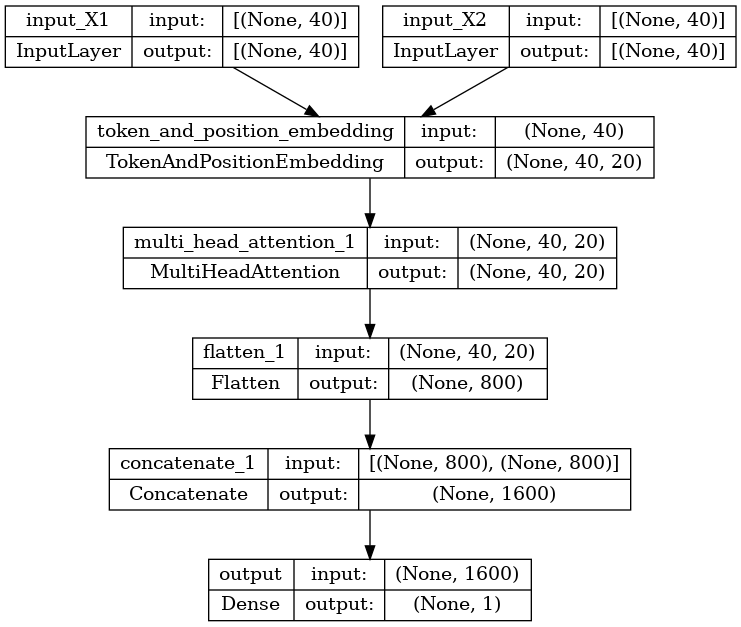

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)
callbacks = [es]

epochs = 20
train_history = model.fit([X_train1, X_train2],
                          y_train,
                          validation_data=([X_val1, X_val2], y_val),
                          batch_size=64, epochs=epochs, callbacks=callbacks)

Epoch 1/20
772/772 [==============================] - 5s 5ms/step - loss: 0.6860 - accuracy: 0.5610 - val_loss: 0.6822 - val_accuracy: 0.5642
Epoch 2/20
772/772 [==============================] - 4s 5ms/step - loss: 0.6719 - accuracy: 0.5882 - val_loss: 0.6927 - val_accuracy: 0.5508
Epoch 3/20
772/772 [==============================] - 4s 5ms/step - loss: 0.6551 - accuracy: 0.6065 - val_loss: 0.6993 - val_accuracy: 0.5576
Epoch 3: early stopping


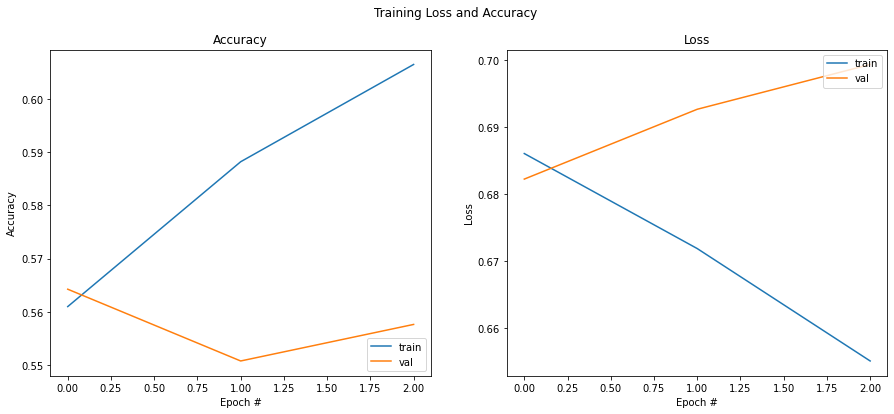

----------
Loss: 0.68
Accuracy: 56.05 %


In [ ]:
n_epochs = len(train_history.history["loss"])
plot_training(n_epochs, train_history)

score = model.evaluate([X_test1, X_test2], y_test, verbose=0)
print ("-"*10)
print ("Loss: {:.2f}".format((score[0])))
print ("Accuracy: {:.2f} %".format(score[1]*100))

## Añade una capa bidirectional lstm

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong> Es muy interesante no alimentar directamente la capa de embeddings a la capa de atención. Lo optimo es obtener información enriquecida, por ejemplo a través de una LSTM. Por ello:
    
*  Añade una capa bidireccional LSTM justo antes de la capa MultiHeadAttention
*  Como antes, muestra el resumen, los bloques y los resultados de entrenamiento y test.
*  Comenta y discute los resultados
*  Para que sirve una capa bidireccional? Es útil cuando tenemos lenguaje natural? Y por ejemplo en una serie de bolsa?


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> </p>
</div>

In [ ]:
# Ahora incluimos la LSTM bidireccional
max_length = 40
embedding_dim = 20
input_length = max_length

X1_input = Input(shape=(input_length,), name="input_X1")
X2_input = Input(shape=(input_length,), name="input_X2")

embeddor = TokenAndPositionEmbedding(max_length, num_words, embedding_dim)
encoder1 = Bidirectional(LSTM(8, return_sequences=True))
multihead = MultiHeadAttention(num_heads=2, key_dim=embedding_dim, dropout=0)
flatten = Flatten()

x1 = embeddor(X1_input)
x1 = encoder1(x1)
x1 = multihead(x1,x1)
x1 = flatten(x1)

x2 = embeddor(X2_input)
x2 = encoder1(x2)
x2 = multihead(x2,x2)
x2 = flatten(x2)

x = concatenate([x1, x2])

output = Dense(1, activation="sigmoid", name="output")(x)

model = Model(inputs=[X1_input, X2_input], outputs=output, name="LSTM")

In [ ]:
model.compile(optimizer="Adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])

model.summary()

Model: "LSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_X1 (InputLayer)          [(None, 40)]         0           []                               
                                                                                                  
 input_X2 (InputLayer)          [(None, 40)]         0           []                               
                                                                                                  
 token_and_position_embedding_1  (None, 40, 20)      100800      ['input_X1[0][0]',               
  (TokenAndPositionEmbedding)                                     'input_X2[0][0]']               
                                                                                                  
 bidirectional (Bidirectional)  (None, 40, 16)       1856        ['token_and_position_embedding

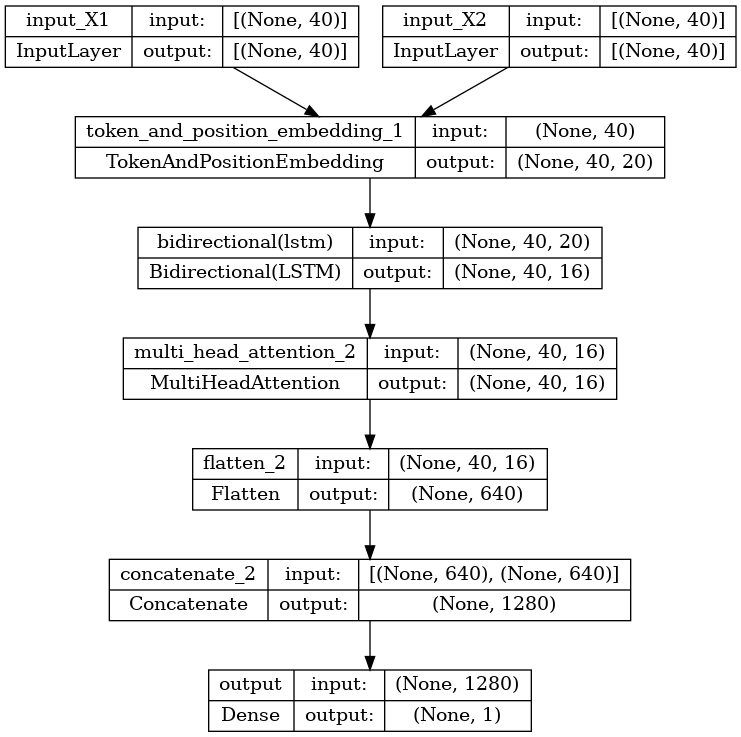

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
callbacks = [es]

epochs = 20
train_history = model.fit([X_train1, X_train2],
                          y_train,
                          validation_data=([X_val1, X_val2], y_val),
                          batch_size=64, epochs=epochs, callbacks=callbacks)

Epoch 1/20
772/772 [==============================] - 16s 17ms/step - loss: 0.6830 - accuracy: 0.5667 - val_loss: 0.7392 - val_accuracy: 0.5586
Epoch 2/20
772/772 [==============================] - 13s 17ms/step - loss: 0.6586 - accuracy: 0.6021 - val_loss: 0.6880 - val_accuracy: 0.5635
Epoch 3/20
772/772 [==============================] - 13s 16ms/step - loss: 0.6464 - accuracy: 0.6120 - val_loss: 0.6895 - val_accuracy: 0.5631
Epoch 4/20
772/772 [==============================] - 13s 16ms/step - loss: 0.6393 - accuracy: 0.6169 - val_loss: 0.6981 - val_accuracy: 0.5596
Epoch 5/20
772/772 [==============================] - 12s 16ms/step - loss: 0.6355 - accuracy: 0.6209 - val_loss: 0.7007 - val_accuracy: 0.5589
Epoch 5: early stopping


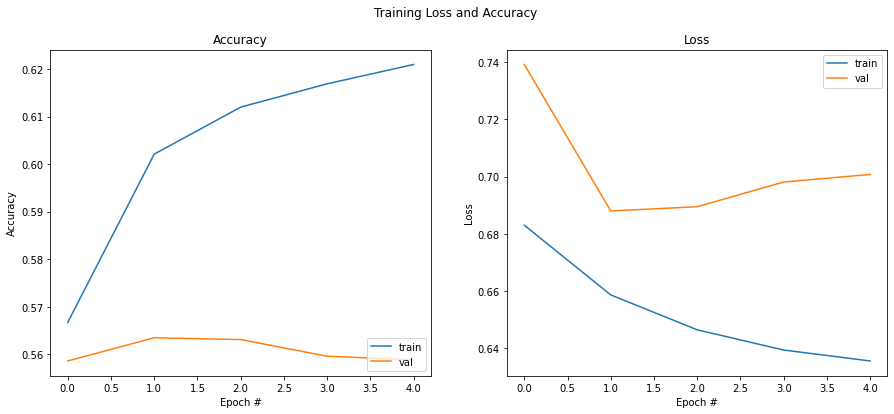

----------
Loss: 0.68
Accuracy: 56.44 %


In [ ]:
n_epochs = len(train_history.history["loss"])
plot_training(n_epochs, train_history)

score = model.evaluate([X_test1, X_test2], y_test, verbose=0)
print ("-"*10)
print ("Loss: {:.2f}".format((score[0])))
print ("Accuracy: {:.2f} %".format(score[1]*100))

## 3. Utilizando arquitecturas preentrenadas para reforzar los datos de entrenamiento

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [2 pts.]:</strong> En determinadas ocasiones puede ser buena idea utilizar modelos preentrenados no solo para finetunearlos a nuestro dominio, sino simplemente para ser capaces de generar nuevos datos de entrenamiento. En nuestro caso parece que no tenemos suficientes datos ya que habrás observado problemas de sobreajuste. Por ello:
    
*  Utiliza el modelo de https://huggingface.co/Vamsi/T5_Paraphrase_Paws para generar nuevos datos de train. Puedes utilizar la estrategia que consideres oportuna para crear nuevas parafrases. Genera ejemplos tanto de parafrases como de no parafrases
*  Reentrena la arquitectura que has construido para intentar mejorar los resultados obtenidos hasta ahora.
*  Adicionalmente intenta mejorar los resultados modificando la arquitectura.
*  Comenta y discute tus resultados
*  Cual puede ser el problema o el limitante de utilizar datos sintéticos generados por una arquitectura preentrenada?


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Solución:</strong> </p>
</div>

In [ ]:
# Obten el modelo preentrenado
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import transformers.models.t5
from transformers.models.t5 import configuration_t5

tokenizer = AutoTokenizer.from_pretrained("Vamsi/T5_Paraphrase_Paws")
model = AutoModelForSeq2SeqLM.from_pretrained("Vamsi/T5_Paraphrase_Paws")


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
# A modo de muestra se generan 100 nuevas parafrases. De igual forma se generar posteriormente ejemplos negativos
number = 100
ba = []
for item in train_sentence1[0:number]:
    sentence = item

    text =  "paraphrase: " + sentence + " </s>"
    encoding = tokenizer.encode_plus(text,pad_to_max_length=True, return_tensors="pt")
    input_ids, attention_masks = encoding["input_ids"], encoding["attention_mask"]
    outputs = model.generate(
        input_ids=input_ids, attention_mask=attention_masks,
        max_length=256,
        do_sample=True,
        top_k=120,
        top_p=0.95,
        early_stopping=True,
        num_return_sequences=1
    )

    for output in outputs:
        line = tokenizer.decode(output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
        ba.append(line)

In [ ]:
# Concatena los datos a los originales, también para y_train
train_sentence1 = train_sentence1 + train_sentence1[0:number]
train_sentence2 = train_sentence2 + ba
y_train = np.concatenate((y_train, np.asarray([1]*number)), axis=0)

# Añadiendo ejemplos negativos y positivos
# train_sentence1 = train_sentence1 + train_sentence1[0:number] + train_sentence1[len(train_sentence1) - number::]
# train_sentence2 = train_sentence2 + ba + train_sentence2[0:number]
# y_train = np.concatenate((y_train, np.asarray([1]*number), np.asarray([0]*number)), axis=0)

In [ ]:
# Es necesario volver a entrenar el tokenizador y volver a tokenizar
num_words=5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, oov_token='-OOV-')
tokenizer.fit_on_texts(train_sentence1 + train_sentence2)

# Regenera los datos tokenizados
X_train_tok1 = tokenizer.texts_to_sequences(train_sentence1)
X_train_tok2 = tokenizer.texts_to_sequences(train_sentence2)
X_train1 = tf.keras.preprocessing.sequence.pad_sequences(X_train_tok1, maxlen=max_length)
X_train2 = tf.keras.preprocessing.sequence.pad_sequences(X_train_tok2, maxlen=max_length)

In [ ]:
# Finalmente reevalua el modelo
# Modificamos el dropout de la multihead y de la LSTM a 0.2 para intentar evitar tanto overfitting
max_length = 40
embedding_dim = 20
dropout = 0.2
input_length = max_length

X1_input = Input(shape=(input_length,), name="input_X1")
X2_input = Input(shape=(input_length,), name="input_X2")

embeddor = TokenAndPositionEmbedding(max_length, num_words, embedding_dim)
encoder1 = Bidirectional(LSTM(8, dropout=dropout, return_sequences=True))
multihead = MultiHeadAttention(num_heads=2, key_dim=embedding_dim, dropout=dropout)
flatten = Flatten()

x1 = embeddor(X1_input)
x1 = encoder1(x1)
x1 = multihead(x1,x1)
x1 = flatten(x1)

x2 = embeddor(X2_input)
x2 = encoder1(x2)
x2 = multihead(x2,x2)
x2 = flatten(x2)

x = concatenate([x1, x2])

# Output layer
output = Dense(1, activation="sigmoid", name="output")(x)


# Model definition
model = Model(inputs=[X1_input, X2_input], outputs=output, name="Mejorado")

# Model compilation
model.compile(optimizer="Adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "Mejorado"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_X1 (InputLayer)          [(None, 40)]         0           []                               
                                                                                                  
 input_X2 (InputLayer)          [(None, 40)]         0           []                               
                                                                                                  
 token_and_position_embedding_2  (None, 40, 20)      100800      ['input_X1[0][0]',               
  (TokenAndPositionEmbedding)                                     'input_X2[0][0]']               
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 40, 16)      1856        ['token_and_position_embed

In [ ]:
# stop traning if there increase in loss
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
callbacks = [es]

epochs = 20
train_history = model.fit([X_train1, X_train2],
                          y_train,
                          validation_data=([X_val1, X_val2], y_val),
                          batch_size=64, epochs=epochs, callbacks=callbacks)

Epoch 1/20
774/774 [==============================] - 17s 18ms/step - loss: 0.6859 - accuracy: 0.5600 - val_loss: 0.6837 - val_accuracy: 0.5612
Epoch 2/20
774/774 [==============================] - 14s 18ms/step - loss: 0.6631 - accuracy: 0.5955 - val_loss: 0.6870 - val_accuracy: 0.5599
Epoch 3/20
774/774 [==============================] - 14s 18ms/step - loss: 0.6486 - accuracy: 0.6098 - val_loss: 0.6926 - val_accuracy: 0.5585
Epoch 4/20
774/774 [==============================] - 14s 18ms/step - loss: 0.6414 - accuracy: 0.6145 - val_loss: 0.6957 - val_accuracy: 0.5592
Epoch 4: early stopping


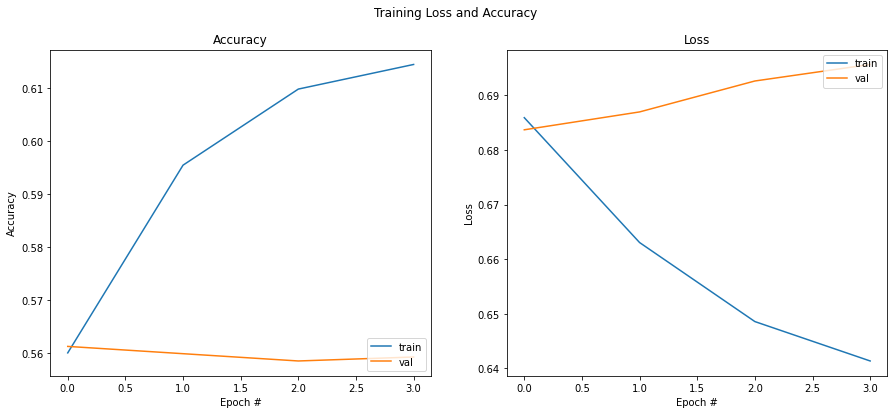

----------
Loss: 0.68
Accuracy: 56.20 %


In [ ]:
n_epochs = len(train_history.history["loss"])
plot_training(n_epochs, train_history)

score = model.evaluate([X_test1, X_test2], y_test, verbose=0)
print ("-"*10)
print ("Loss: {:.2f}".format((score[0])))
print ("Accuracy: {:.2f} %".format(score[1]*100))